In [112]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import gudhi

from functions.data_filtering import ICAO_codes, large_gap_filter
from functions.data_processing import flight_pers, sublevelset_persistence
from functions.data_loading import linkage_cluster_persistances, flights_from_query

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from traffic.core import Traffic, Flight
from gudhi.representations import Landscape

seed = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
# The flights can be converted into a Traffic object
count = 500
with_GA_flights = flights_from_query(None, count, "data/with_GA_flights.pkl")
without_GA_flights = flights_from_query(None, count, "data/without_GA_flights.pkl")

In [114]:
with_GA_flights = list(filter(large_gap_filter, with_GA_flights))
without_GA_flights = list(filter(large_gap_filter, without_GA_flights))

with_GA_labels = np.ones(len(with_GA_flights))
without_GA_labels = np.zeros(len(without_GA_flights))

flights = with_GA_flights + without_GA_flights
labels = np.concatenate((with_GA_labels, without_GA_labels))

trees, paths = flight_pers(flights)
sub_persistence, sub_paths = sublevelset_persistence(flights)

100%|██████████| 1709/1709 [00:18<00:00, 93.23it/s] 


In [115]:
from tqdm import tqdm
baseline = []


for dataset in [with_GA_flights, without_GA_flights]:
    for flight in tqdm(dataset, total=len(dataset)):
        data = flight.data.copy(deep=True)
        
        unwrapped = np.unwrap(np.deg2rad(data["track"]), period=2 * np.pi, discont=np.pi)
        unwrapped_diff = unwrapped.max() - unwrapped.min()
        
        max_velocity = data["groundspeed"].max()
        min_velocity = data["groundspeed"].min()
        mean_velocity = data["groundspeed"].mean()
        max_heading = data["vertical_rate"].max()
        min_heading = data["vertical_rate"].min()
        mean_heading = data["vertical_rate"].mean()
        longitude_diff = data["longitude"].max() - data["longitude"].min()
        latitude_diff = data["latitude"].max() - data["latitude"].min()
        
        baseline.append([unwrapped_diff, max_velocity, min_velocity, mean_velocity, max_heading, min_heading, mean_heading, longitude_diff, latitude_diff])

100%|██████████| 849/849 [00:00<00:00, 2218.49it/s]


In [116]:
resolution = 10
n_landscapes = 3
landscape = Landscape(resolution=resolution, num_landscapes=n_landscapes)
landscapes = []
sub_landscapes = []

for i in trees:
    landscapes.append(landscape.fit_transform([i.persistence_intervals_in_dimension(1)]))
for i in sub_persistence:
    sub_landscapes.append(landscape.fit_transform([i]))

baseline = np.array(baseline)

landscapes = np.array(landscapes)
landscapes = landscapes.reshape(landscapes.shape[0], landscapes.shape[2])

sub_landscapes = np.array(sub_landscapes)
sub_landscapes = sub_landscapes.reshape(sub_landscapes.shape[0], sub_landscapes.shape[2])

In [117]:
labels.shape

(1709,)

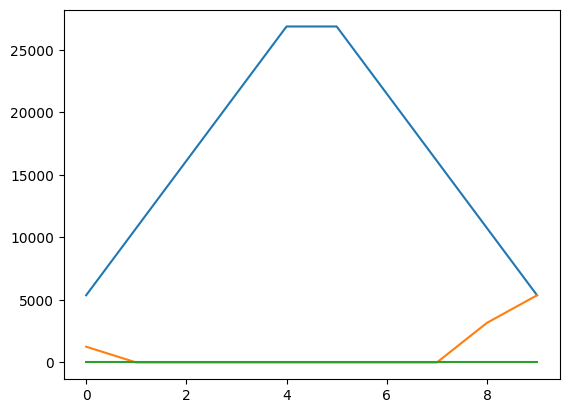

In [118]:
diagram = 8
for i in range(n_landscapes):
    plt.plot(sub_landscapes[diagram][i*resolution:(i+1)*resolution])

In [119]:
X = baseline
X = np.concatenate((X, landscapes), axis= 1)
X = np.concatenate((X, sub_landscapes), axis= 1)
mask = ~np.any(np.isnan(X), axis=1)
X = X[mask]
Y = labels[mask]

indices = np.arange(len(X))

x_train, x_test_val, y_train, y_test_val, indices_train, indices_test_val = train_test_split(X, Y, indices, test_size=0.3, random_state=seed)
x_test, x_val, y_test, y_val, indices_test, indices_val = train_test_split(x_test_val, y_test_val, indices_test_val, test_size=0.5, random_state=seed)

In [120]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree
from sklearn import svm

models = {
    "Decition Tree" : [tree.DecisionTreeClassifier(random_state=seed), {
        "min_samples_leaf" : [2, 3],
        "min_samples_split" : [2, 3]
    }],
    "Support Vector Machines" : [svm.SVC(random_state=seed), {
        "C" : [1, 2, 3], 
        "break_ties": [True, False], 
        "probability": [True, False]
    }],
    "Base line" : [DummyClassifier(strategy = "most_frequent"), {
        
    }],
    "Multi-layer Perception" : [MLPClassifier(random_state=seed, max_iter = 5000), {
        "hidden_layer_sizes" : [10, 20, 30], 
        
    }],
    "K Nearest Neighbors" : [KNeighborsClassifier(), {
        "n_neighbors" : [5, 10, 20, 40], 
        "p": [1, 2, 3]
    }],
    "Random Forrest Regressor" : [RandomForestClassifier(random_state=seed), {
        "max_depth": [2, 3], 
        "n_estimators" : [50, 100, 300]
    }],
    "Decision Tree Regressor" : [DecisionTreeClassifier(random_state=seed), {
        "min_samples_split" : [2, 3, 4],
        "min_samples_leaf" : [1, 2, 3]
    }],
}

In [121]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV

datalist = []

for i in models.keys():
    #does the gridsearch on the models
    model = GridSearchCV(models[i][0], models[i][1])
    #makes a prediction
    prediction = model.fit(x_train, y_train).predict(x_test)
    #finds out how good that prediction is
    
    balanced_accuracy = balanced_accuracy_score(y_test, prediction)
    datalist.append([model.best_estimator_, balanced_accuracy])

In [122]:
for i, j in datalist:
    print(f"{i.__repr__(): <70}: {j: .3}")

DecisionTreeClassifier(min_samples_leaf=2, random_state=42)           :  0.988
SVC(C=3, break_ties=True, probability=True, random_state=42)          :  0.938
DummyClassifier(strategy='most_frequent')                             :  0.5
MLPClassifier(hidden_layer_sizes=30, max_iter=5000, random_state=42)  :  0.984
KNeighborsClassifier()                                                :  0.937
RandomForestClassifier(max_depth=3, n_estimators=50, random_state=42) :  0.984
DecisionTreeClassifier(min_samples_split=4, random_state=42)          :  0.988


In [123]:
new_x_train =  np.concatenate((x_train, x_test), axis=0)
new_y_train = np.concatenate((y_train, y_test), axis=0)
best_model = sorted(datalist, key=lambda x: x[1], reverse=True)[0][0]

prediction = best_model.fit(new_x_train, new_y_train).predict(x_val)
balanced_accuracy = balanced_accuracy_score(y_val, prediction)
balanced_accuracy

0.9763779527559056

In [124]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, prediction)

array([[129,   0],
       [  6, 121]], dtype=int64)

Where the columns is prediction and the rows are the true value.
i will note that the dataset is not 100% accurate. there are false positives:



The GA detection algorithm sometimes fails to detect GAs either:
* if GAs are initialized early on the approach and have no or only a short climb phase, 
* if GAs have a very tight turn radius and only a short leg on the final approach (as usually performed by small general aviation aircraft), or 
* if GAs directly divert to other airports.

### adding sublevel set height:
this doesnt seem to improve the results, and mostly just confuses the models :/


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

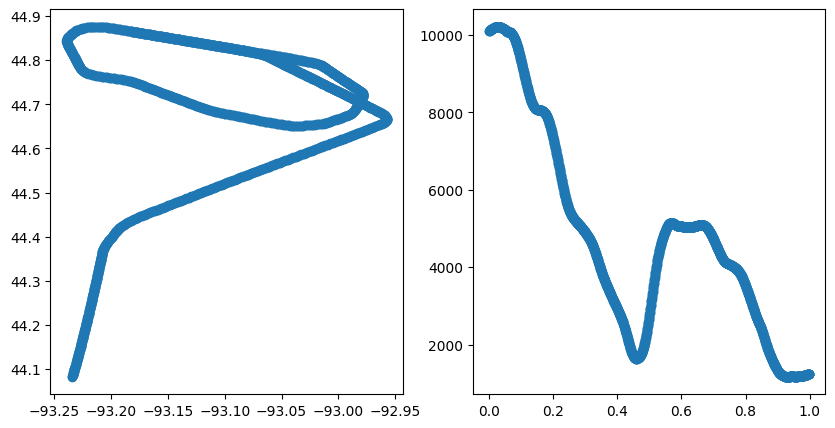

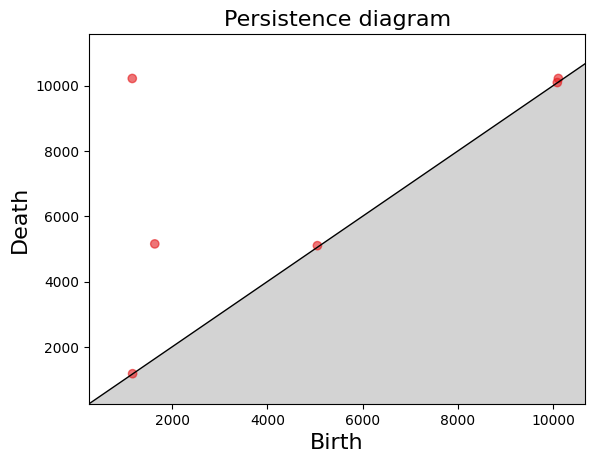

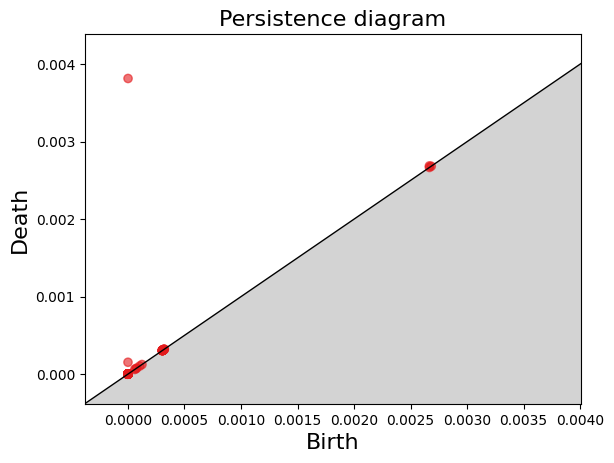

In [127]:
false_negatives = np.where(np.logical_and(y_val == 1, prediction == 0))[0]
false_positives = np.where(np.logical_and(y_val == 0, prediction == 1))[0]

index = 5
index = indices_val[false_negatives[index]]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
path = paths[index]
axs[0].scatter(path[:, 1], path[:, 0])

path = sub_paths[index]
x_values = [x / len(path) for x in range(len(path))]
axs[1].scatter(x_values, path)

gudhi.persistence_graphical_tools.plot_persistence_diagram(sub_persistence[index])
gudhi.persistence_graphical_tools.plot_persistence_diagram(trees[index].persistence_intervals_in_dimension(1))